In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
%matplotlib inline

In [2]:
def InitialCondition_Delta(r,r0,Sigma0):
    dr=r[1]-r[0]
    Sigma=np.zeros(r.size)
    delta= np.where(np.fabs(r-r0)<=dr)[0]
    
    Sigma[delta]=Sigma0* (1.0 - np.fabs(r-r0)[delta]/dr) 
    return Sigma

def InitialCondition_PowerLaw(r,r0,Sigma0,exp):
    
    return Sigma0*np.power(r/r0,exp)

In [3]:
def BoundaryCondition_InnerCopy(r,Sigma):
    Sigma[0]=Sigma[1]
    
def BoundaryCondition_OuterCopy(r,Sigma):
    Sigma[nr-1]=Sigma[nr-2]
    

def BoundaryCondition_Inner(r,Sigma,boundary):
    Sigma[0]=boundary
    
def BoundaryCondition_Outer(r,Sigma,boundary):
    Sigma[-1]=boundary    

In [4]:
def CFL_Condition_Diff(dr,Diffusion):
    if Diffusion>0:
        Courant_Diff= 0.3*dr*dr/Diffusion
        return Courant_Diff
    else:
        return np.infty
    
def CFL_Condition_Vel(dr,u):
    v_max=np.amax(u)
    if v_max>0:
        Courant_Vel= np.divide(0.1*dr,v_max)
        return np.amin(Courant_Vel)
    else:
        return np.infty

In [5]:
def Compute_Diffusion(r,Sigma,visc):
    #Following equation 5.8 in the diffusion form
    '''
    #This does NOT work!
    dr=r[1]-r[0]
    Diff=3.0*visc    
    dq=np.zeros_like(q)    
    dq[1:nr-1]= Diff*(q[2:nr] - 2.0*q[1:nr-1] + q[0:nr-2])/(dr*dr)
    '''
    
    #This Works
    s=2.0*np.sqrt(r)
    q=np.multiply(Sigma,s)
    
    dq_dr2=np.zeros_like(q)
    dq_dr2[1:nr-1]= np.divide(q[2:nr]-q[1:nr-1],s[2:nr]-s[1:nr-1]) - np.divide(q[1:nr-1]-q[0:nr-2],s[1:nr-1]-s[0:nr-2])
    dq_dr2[1:nr-1]= 2.0*np.divide(dq_dr2[1:nr-1],s[2:nr]-s[0:nr-2])
    
    dSigma_dt=12.0*visc*np.divide(dq_dr2,np.power(s,3.0))
    
    return dSigma_dt
    

In [ ]:
def Compute_Velocity(r,Sigma,visc):
    nr=r.size
    dr=r[1]-r[0]
    Sigr= np.multiply(Sigma,np.sqrt(r))
    
    r_05=0.5*(r[0:nr-1]+r[1:nr])
    Sigr_05= 0.5*(Sigr[0:nr-1]+Sigr[1:nr])
    d_Sigr_05= (Sigr[1:nr]-Sigr[0:nr-1])/dr

    u_05 = -3.0*visc*np.divide(d_Sigr_05,Sigr_05)
    u_inter=interp1d(r_05,u_05,kind="linear",fill_value="extrapolate")
    
    return u_inter(r)

In [ ]:
def DonnorCell_Advection(r,q,u):
    nr=r.size
    dr=r[1]-r[0]
    
    u_05= 0.5*(u[0:nr-1]+u[1:nr]) #Velocity at the Interfaces
    flux_05= np.zeros(nr-1)  #Flux at the interfaces
    
    positive=np.where(u_05>0)[0]  #Interfaces where the flux comes from the left
    negative=np.where(u_05<0)[0]  #Interfaces where the flux comes from the right
        
    flux_05[positive]= np.multiply(q[positive], u_05[positive])
    flux_05[negative]= np.multiply(q[negative+1], u_05[negative])
    
    q_flux=np.zeros(nr)
    q_flux[1:nr-1]= (flux_05[0:nr-2]-flux_05[1:nr-1])/dr  #Notice that the cell 0 and nr-1 are ignored
    
    return q_flux

In [6]:
def AnalyticalSolution(r,t,r0,m,visc):
    x=r/r0
    tau= t*12.0*visc/(r0*r0)
    
    return m/(np.pi*r0**2*tau)*x**(-0.25)*np.exp(-(1+x*x)/tau)*iv(0.25,2.*x/tau)
    
    #return m_disk/(np.pi*r0*r0)*(1.0/tau)*np.power(x,-0.25)*np.exp(-(1.0+np.square(x))/tau)*iv(0.25,2.0*x/tau)
    
    

In [20]:
Mstar=1.0           #Solar Mass
r0=1.0              #AU
visc=0.001          #Weird Units
m_disk=0.01*Mstar   #Disk mass

t_orbit=2.0*np.pi
t_visc=r0*r0/(12.0*visc)

nr=500
r_min=0.01
r_max=2.0

dr=(r_max-r_min)/nr
r=np.linspace(r_min+0.5*dr,r_max-0.5*dr,num=nr,endpoint=True)


t_start=0.0*t_visc
t_output=t_visc*np.power(2.0, 2.0*np.arange(1,6)-1.0)/1000.
dt=0.0001*t_visc



Sigma0=m_disk/(2.0*np.pi*r0*dr)
Sigma=InitialCondition_Delta(r,r0,Sigma0)+0.0001*Sigma0
#Sigma=InitialCondition_PowerLaw(r,r0,Sigma0,-1.5)

floor_Sigma=np.amin(Sigma)

In [21]:
t=t_start
t_save=t_output[0]
s=0


Output_Dens=[]
Output_Dens.append(np.copy(Sigma))

while t<t_output[-1]:
    
    #Find the timestep using Courant Condition
    dt_0=np.amin([dt,t_save-t, CFL_Condition_Diff(dr,3.0*visc)])
    
    #Evolve the Density through Diffusion
    dSigma_dt=Compute_Diffusion(r,Sigma,visc)
    Sigma+=dSigma_dt*dt_0
    
    #Apply Boundary Conditions
    #Notice that the cells 0 and nr-1 are treated as ghost cells and never touched except by the boundary conditions
    #BoundaryCondition_BothSides(r,Sigma,0.0)
    BoundaryCondition_InnerCopy(r,Sigma)
    BoundaryCondition_Outer(r,Sigma,floor_Sigma)
    
    
    
    #Check if it is time to save
    t+=dt_0
    if t>=t_save:
        s=s+1
        if s<t_output.size:
            t_save=t_output[s]
        Output_Dens.append(np.copy(Sigma))
    #Update the Time


C:\Users\matga\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


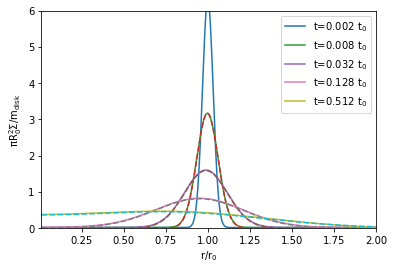

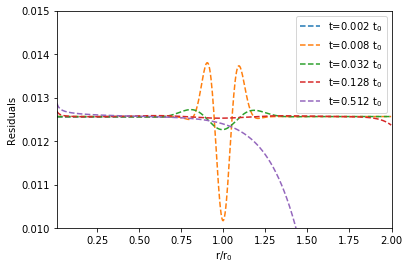

In [23]:
plt.figure(1)
plt.xlabel("$\mathdefault{r/r_0}$")
plt.ylabel("$\mathdefault{\pi R_0^2\Sigma/m_{disk}}$")
plt.xlim([r_min,r_max])
plt.ylim([0.0,6.0])

plt.figure(2)
plt.xlabel("$\mathdefault{r/r_0}$")
plt.ylabel("Residuals")
plt.xlim([r_min,r_max])
plt.ylim([0.010,0.015])


for s in range(1,len(Output_Dens)):
    time=t_output[s-1]    
    sigma_analytic=AnalyticalSolution(r,time,r0,m_disk,visc)
    
    plt.figure(1)
    plt.plot(r/r0, np.pi*r0*r0*Output_Dens[s]/m_disk,label="t="+str(time/t_visc)+" $\mathdefault{t_0}$" )
    plt.plot(r/r0,sigma_analytic*np.pi*r0*r0/m_disk,'--')
    plt.legend()

    plt.figure(2)
    plt.plot(r/r0,(Output_Dens[s]-sigma_analytic)*np.pi*r0*r0/m_disk,'--',label="t="+str(time/t_visc)+" $\mathdefault{t_0}$" )
    plt.legend()


In [ ]:
'''
    
    plt.plot(r/r0, np.pi*r0*r0*AnalyticalSolution(r,t_visc*2.0**(2.0*s-1.0)/1000.0,r0,m_disk,visc)/Sigma0,"r--")
    plt.legend()
'''